## 导包

In [1]:
import os
import pandas as pd 
import numpy as np
import scorpyo as sp

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import time

from sklearn.model_selection import KFold
from scipy.stats import spearmanr
from lightgbm import LGBMRegressor

In [2]:
path_project = r'/Users/liliangshan/workspace/python/01_datasets/novozymes-enzyme-stability-prediction'

# path dir
path_row_data = os.path.join(path_project, 'row_data')
path_new_data = os.path.join(path_project, 'new_data')
path_results  = os.path.join(path_project, 'results')

# path row_data
path_train = os.path.join(path_row_data, 'train.csv')
path_train_update = os.path.join(path_row_data, 'train_updates_20220929.csv')
path_test  = os.path.join(path_row_data, 'test.csv')
path_sample_submission = os.path.join(path_row_data, 'sample_submission.csv')

# 
path_submission = os.path.join(path_results, 'submission_20221010_01_2kmer.csv')
path_submission_sub = os.path.join(path_results, 'submission.csv')

## 数据读取

In [3]:
df_train = sp.read_data(path_train)
df_train_update = sp.read_data(path_train_update)
df_test  = sp.read_data(path_test)

In [4]:
df_train = df_train[~df_train['seq_id'].isin(df_train_update['seq_id'])].reset_index(drop=True)
df_train.shape

(28956, 5)

In [5]:
df_train.head()

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5


## 数据探索性分析

### detect

In [6]:
df_detect = sp.detect(df_train)
df_detect

,feat_name_row,type,size,missing,unique,zero_ratio,negative_ratio,top1_all_value,top1_all_ratio,mean_or_top1,std_or_top2,min_or_top3,1%_or_top4,10%_or_top5,50%_or_bottom5,75%_or_bottom4,90%_or_bottom3,99%_or_bottom2,max_or_bottom1
0,seq_id,int64,28956,0.000,28956,0.0,0.0,0,0.000,15744.917,9251.18,0.0,303.55,2966.5,15587.5,23902.25,28444.5,31099.45,31389.0
1,protein_sequence,object,28956,0.000,27375,0.0,NaN,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,0.000,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,MKIKTGARILALSALTTMMFSASALAKIEEGKLVIWINGDKGYNGL...,QDWLTFQKKHITNTRDVDCDNILSTNLFHCKDKNTFIYSRPEPVKA...,MERLTLLGLPLDPVDMEEALKRIGGFLQEERTHQVVTLNPEIAVRA...,MERLQRLMMNSKVGSADTGRDDTKETVYISSIALLKMLKHGRAGVP...,MERLQRIFGAGGGLGHASPDSPTLDTSEQVYISSLALLKMLKHGRA...,MERLQKVIARAGIASRRKAEELILQGRVKVNGRVVKELGVKVGPRD...,YYVPDEYWQSLEVAHKLTFGYGYLTWEWVQGIRSYVYPLLIAGLYK...
2,pH,float64,28956,0.010,104,0.0,0.0,7.0,0.880,6.873,0.793,1.99,2.7,7.0,7.0,7.0,7.0,8.0,11.0
3,data_source,object,28956,0.033,324,0.0,NaN,doi.org/10.1038/s41592-020-0801-4,0.847,doi.org/10.1038/s41592-020-0801-4:84.70%,10.1021/acscatal.9b05223:0.73%,10.1016/j.bpc.2006.10.014:0.64%,10.7554/eLife.54639:0.52%,10.1007/s00253-018-8872-1:0.29%,10.1021/bi951892w:0.00%,10.1074/jbc.M001132200:0.00%,10.1021/bi00485a004:0.00%,10.1021/bi00368a024:0.00%,10.1016/j.ijbiomac.2008.12.016:0.00%
4,tm,float64,28956,0.000,725,0.0,0.0,50.0,0.007,51.36,12.061,25.1,33.6,39.5,48.8,54.6,68.5,91.0,130.0


### 一条蛋白质有多个结果

In [7]:
my_seq = df_train.protein_sequence.value_counts().index[0]
df_train[df_train['protein_sequence']==my_seq]

,seq_id,protein_sequence,pH,data_source,tm
20075,22180,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,7.00,10.1021/bi00252a018,83.1
20076,22181,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,3.20,10.1021/bi00252a018,51.3
20077,22182,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,3.21,10.1021/bi00252a018,51.3
20078,22183,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,3.15,10.1021/bi00252a018,50.2
20079,22184,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,3.16,10.1021/bi00252a018,49.9
20080,22185,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,9.50,10.1021/bi00252a018,82.6
20081,22186,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,3.07,10.1021/bi00252a018,47.3
20082,22187,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,9.75,10.1021/bi00252a018,82.3
20083,22188,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,2.90,10.1021/bi00252a018,42.3
20084,22189,MRNTGAGPSPSVSRPPPSAAPLSGAALAAPGDAPSALYAPSALVLT...,3.04,10.1021/bi00252a018,46.3


### 氨基酸数量

In [8]:
train_dict = dict(sorted(Counter(''.join(df_train['protein_sequence'].values)).items()))
test_dict = dict(sorted(Counter(''.join(df_test['protein_sequence'].values)).items()))

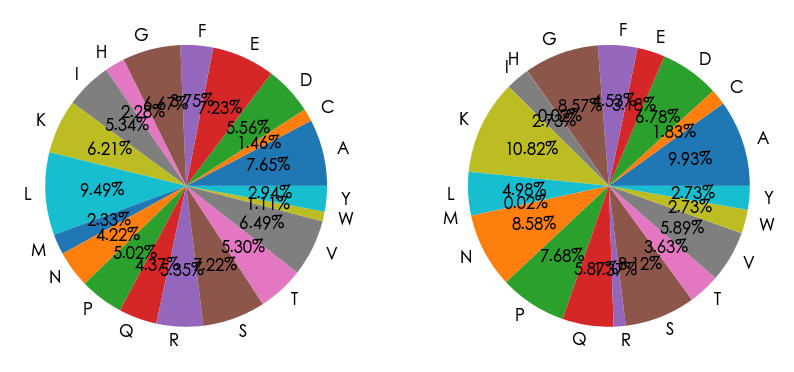

In [9]:
import matplotlib

"""
font:设置中文
"""
matplotlib.rcParams['font.family'] = ['Heiti TC']
#设置大小
plt.rcParams['figure.figsize']=[10,5]

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

# plot each pie chart in a separate subplot
ax1.pie(x=[i for i in train_dict.values()],labels=train_dict.keys(),autopct="%0.2f%%", textprops = {'fontsize':12, 'color':'k'},)
ax2.pie(x=[i for i in test_dict.values()],labels=test_dict.keys(), autopct="%0.2f%%", textprops = {'fontsize':12, 'color':'k'},)

# 显示图例
#plt.legend()
plt.show()

In [10]:
len(train_dict)

20

## 特征工程

### K-mer
在生信中，k-mer指生物序列中长度为k的子序列。k-mer包含着生物序列的两个基本特征：
1. 单体组分信息
2. 序列顺序信息

由于氨基酸的种类比较多，故这里最多做到2-mer,但同时可考虑gap，建议可尝试不超过5个gap, 共2000特征进行筛选。


In [11]:
sequence_letters = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
N = len(sequence_letters)

def build_vector(sequence, gap=0):
    X = []
    for index, data in enumerate(sequence):
        lists = list(data)
        freq_matrix = np.zeros((N, N))
        
        for j in range(len(lists)):
            if j>gap and j < len(lists)-1-gap:
                index0 = sequence_letters.index(lists[j-1-gap])
                index1 = sequence_letters.index(lists[j])
                index2 = sequence_letters.index(lists[j+1+gap])
                freq_matrix[index1][index0] += 1
                freq_matrix[index1][index2] += 1
        X.append((freq_matrix/(N**2)).reshape(-1))
    
    feats = []
    for i in sequence_letters:
        for j in sequence_letters:
            feats.append(''.join([i, '*'*gap, j]))
    return pd.DataFrame(data=np.array(X), columns=np.array(feats))

In [12]:
feats_01 = build_vector(df_train['protein_sequence'])
feats_02 = build_vector(df_train['protein_sequence'], gap=1)
X, Y = pd.concat([df_train[['pH']], feats_01, feats_02], axis=1), df_train[['tm']]

test_feats_01 = build_vector(df_test['protein_sequence'])
test_feats_02 = build_vector(df_test['protein_sequence'], gap=1)
test = pd.concat([df_test[['pH']], test_feats_01, test_feats_02], axis=1)

## 特征筛选

相关性系数

## Modeling

In [13]:
t1 = time.time()
kf = KFold(n_splits = 5, shuffle = True, random_state=34)
score_list_lgb = []
test_preds_lgb = []
fold = 1

for train_index, test_index in kf.split(X, Y):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_val = Y.iloc[train_index], Y.iloc[test_index]
    
    print("X_train shape is :", X_train.shape, "X_val shape is", X_val.shape)
    y_pred_list = []
    
    model_lgb = LGBMRegressor(
                            n_estimators = 1000,
                            learning_rate = 0.01,
                            num_leaves = 30, 
                             )
    model = model_lgb.fit(X_train, Y_train)
    model_pred = model_lgb.predict(X_val)
    
    score = spearmanr(Y_val, model_pred)[0]
    print('Fold ', str(fold), ' result is:', score, '\n')
    score_list_lgb.append(score)

    test_preds_lgb.append(model_lgb.predict(test))
    fold +=1

t2 = time.time()
print("LGBM model with cross validation take : {:.3f} sn.".format(t2-t1)) 

X_train shape is : (23164, 801) X_val shape is (5792, 801)
Fold  1  result is: 0.5319605367158392 

X_train shape is : (23165, 801) X_val shape is (5791, 801)
Fold  2  result is: 0.5393582949324498 

X_train shape is : (23165, 801) X_val shape is (5791, 801)
Fold  3  result is: 0.524793871724858 

X_train shape is : (23165, 801) X_val shape is (5791, 801)
Fold  4  result is: 0.5333060276782983 

X_train shape is : (23165, 801) X_val shape is (5791, 801)
Fold  5  result is: 0.5295006233537239 

LGBM model with cross validation take : 59.015 sn.


## 结果提交

In [14]:
submission = sp.read_data(path_sample_submission)
submission = pd.DataFrame({'seq_id': submission['seq_id'], 'tm': np.mean(test_preds_lgb,axis=0)})
sp.save_data(submission, path_submission, index=False)
sp.save_data(submission, path_submission_sub, index=False)

In [15]:
# !kaggle competitions submit -c novozymes-enzyme-stability-prediction -f /Users/liliangshan/workspace/python/01_datasets/novozymes-enzyme-stability-prediction/results/submission.csv -m "Message"